In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.optimize import curve_fit, bisect

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, wrap_360, rot, scale_180_from_360, calc_sweep_times
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

from SacNetwork import SacNetwork
# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

In [4]:
model_path = os.path.join(base_path, "sanity")
fig_path = os.path.join(model_path, "angle_figs") 
# fig_path = os.path.join(model_path, "gaba_mirror_angle_figs") 
# fig_path = os.path.join(model_path, "gaba_reroll_angle_figs") 
os.makedirs(fig_path, exist_ok=True)
exts = [".png", ".svg"]

dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
circle = np.radians([0, 45, 90, 135, 180, 225, 270, 315, 0])
dir_rads = np.radians(dir_labels)
wrap_circ = lambda ds: np.r_[ds, ds[0]]
dirs_180 = np.array([ana.scale_180_from_360(d) for d in dir_labels])
dir_sort = np.argsort(dir_labels)
dir_180_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.r_[dirs_180_sorted, -dirs_180_sorted[0]]
full_dir_180 = np.r_[-dirs_180[-1], dirs_180] # from -180 to 180
wrap_full_180 = lambda ds: np.r_[ds[-1], ds]

# conf = configs.sac_mode_config()
conf = configs.decr_weight()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}
conf["sac_uniform_dist"] = {0: False, 1: False}  # unused dummy value
conf["sac_shared_var"] = 30  # unused dummy value
conf["sac_theta_vars"] = {"E": 60, "I": 60}  # unused dummy value
conf["sac_theta_mode"] = "experimental"  # used (supercedes above settings)
# conf["sac_gaba_everywhere"] = "mirror"   # TESTING
# conf["sac_gaba_everywhere"] = "reroll"   # TESTING

diam = lambda dist: 0.5 + 2.58 * np.exp((-dist - 10) / 10)  # dendrite diameter

### Input angle histogram
Symmetrical ACh and asymmetrical GABA wiring

Average GABA synapse count: 170.62


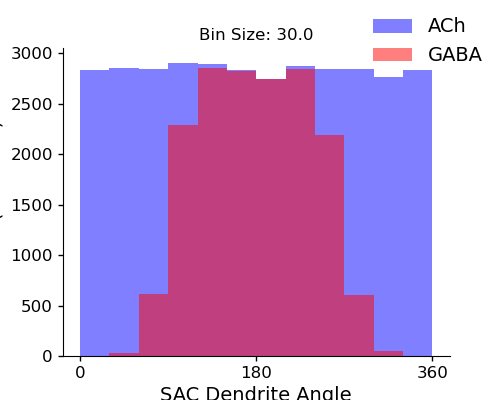

In [5]:
hist_conf = copy.deepcopy(conf)
hist_conf["seed"] = 4
hist_conf["sac_theta_mode"] = "experimental"
hist_nets = 100
angle_hist_fig, angle_hist_ax = ana.sac_angle_distribution(
    hist_conf, 
    rho=1,
    n_nets=hist_nets,
    bins=[12],
    incl_yticks=True,
    ach_clr="blue",
    gaba_clr="red",
    figsize=(5, 4)
)
name = os.path.join(fig_path, "angle_hist_seed%i_%inets" % (hist_conf["seed"], hist_nets))
for ext in [".png", ".svg"]:
    angle_hist_fig.savefig(name + ext, bbox_inches="tight")

### Checking that generated SAC nets look normal
- probability of inputs coincide with direction
- probabilities of plexus inputs appropriately scaled
- sweep timings line up with locations

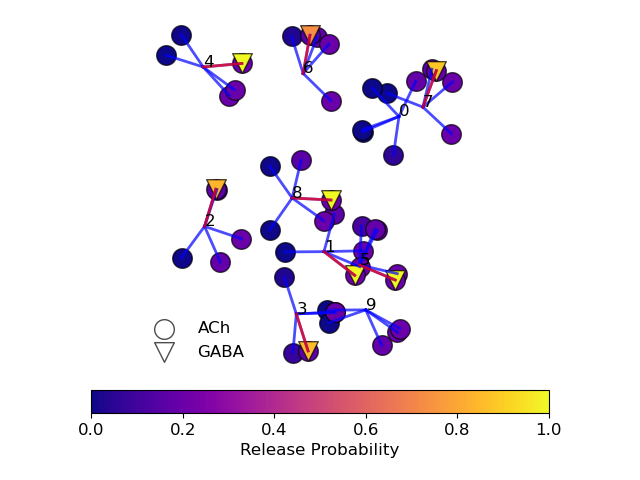

In [6]:
rho = 1.
stim_angle = 180
n_syn = 10
n_plex = 4
seed = 5
show_plex = True

rng = np.random.default_rng(seed)
syn_locs = rng.uniform(low=0, high=200, size=(n_syn, 2)) + np.array([0, 20])
sample_net = SacNetwork(
    syn_locs,
    probs,
    rho,
    conf["sac_uniform_dist"],
    conf["sac_shared_var"],
    conf["sac_theta_vars"],
    conf["sac_gaba_coverage"],
    dir_labels,
    rng,
    offset=conf["sac_offset"],
    theta_mode=conf["sac_theta_mode"],
    cell_pref=0,
    n_plexus_ach=n_plex,
)

sweep_times = calc_sweep_times(
    sample_net.origin,
    dir_rads,
    conf["light_bar"],
    syn_locs,
    sample_net,
    {"NMDA": [0] * len(dir_labels)},
)

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    syn_locs,
    sample_net.bp_locs,
    sample_net.probs,
    dir_labels,
    stim_angle=stim_angle,
    n_syn=n_syn,
    dsgc_alpha=0,
    sac_thickness=2,
    sac_marker_size=200,
    syn_choice_seed=seed,
    show_plex=show_plex,
    # ach_color="green",
    # gaba_color="cyan",
    ach_color="blue",
    gaba_color="red",
    ach_edge="black",
    gaba_edge="black",
    # ach_edge="blue",
    # gaba_edge="red",
    syn_number_size=12,
)
#6 26 37
over_fig.tight_layout()
over_fig.savefig(
    os.path.join(fig_path, "deleteme_schem_plex%i_d%i_seed%i.svg" % (n_plex, stim_angle, seed)), bbox_inches="tight")

In [7]:
probs

{'E': {'null': 0.0, 'pref': 1.0}, 'I': {'null': 0.0, 'pref': 1.0}}

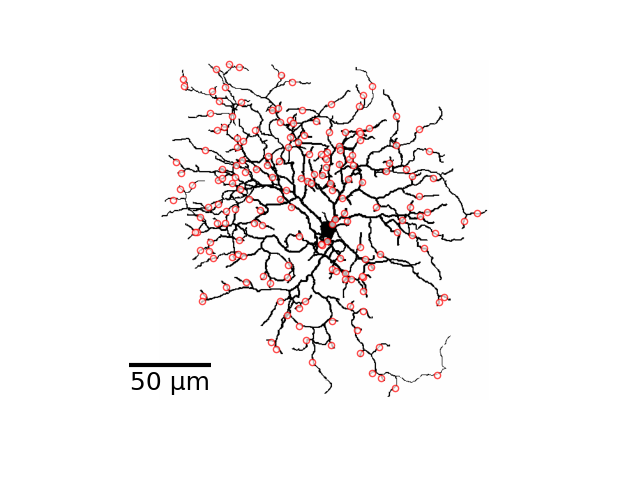

In [8]:
# NOTE: just for making a quick panel for a different thesis chapter
term_syn_locs = Model().syn_locs[:, :2]
term_sample_net = SacNetwork(
    term_syn_locs,
    probs,
    1.,  # rho, irrelevant
    conf["sac_uniform_dist"],
    conf["sac_shared_var"],
    conf["sac_theta_vars"],
    conf["sac_gaba_coverage"],
    dir_labels,
    np.random.default_rng(),
    offset=0,
    theta_mode=conf["sac_theta_mode"],
    cell_pref=0,
    n_plexus_ach=0,
)

term_over_fig, term_over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    term_over_fig,
    term_over_ax,
    term_syn_locs,
    term_sample_net.bp_locs,
    term_sample_net.probs,
    dir_labels,
    dsgc_alpha=1,
    sac_thickness=2,
    sac_marker_size=20,
    show_plex=False,
    # ach_color="blue",
    ach_color="#FFFFFF00",
    gaba_color="red",
    ach_edge="red",
    gaba_edge="black",
    syn_number_size=0,
    show_gaba=False
)
# clean_axes(term_over_ax, remove_spines=["left", "right", "top", "bottom"])
tree_sizex = 50
add_scalebar(
    term_over_ax,
    matchx=False, 
    matchy=False, 
    sizex=tree_sizex, 
    labelx="%i μm" % tree_sizex,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(170, 100),
    textprops={"fontsize": 18},
)
term_over_ax.get_legend().remove()
term_over_fig.set_layout_engine("compressed")

for ext in exts:
    term_over_fig.savefig(os.path.join(fig_path, "terminal_syn_locations" + ext), bbox_inches="tight")

In [9]:
syn_idx = 0
stim_angle_idx = np.argwhere(dir_labels == stim_angle)[0][0]
print("sac net origin = %s" % str(sample_net.origin))
print("relative start pos = %s" % str(conf["light_bar"]["rel_start_pos"]))
print("syn #%i bp loc = %s" % (syn_idx, str(sample_net.bp_locs["E"][0])))
print("syn #%i theta = %s" % (syn_idx, str(sample_net.thetas["E"][syn_idx])))
print("syn #%i activation time for %s deg motion = %f" % (
    syn_idx, str(stim_angle), sweep_times[stim_angle_idx][0]["E"]))
print("syn #%i probability for %s deg motion = %f" % (
    syn_idx, str(stim_angle), sample_net.probs["E"][syn_idx, stim_angle_idx]))

sac net origin = (104.67096015679267, 122.41634458572688)
relative start pos = [-150    0]
syn #0 bp loc = [132.812422   171.32036943]
syn #0 theta = 20.014602091460432
syn #0 activation time for 180 deg motion = 121.858538
syn #0 probability for 180 deg motion = 0.000182


In [10]:
def simple_calc_sweep_times(
    locs, # shape (N, 2 [EI], 2 [XY])
    origin,
    vel=1.0,
    rel_start=np.array([-150, 0]),
    rel_end=np.array([150, 0]),
):
    """Same math as what is used by the model, but factored out for easier direct use here."""
    times = {}  # dir -> syn -> trans
    times = np.zeros((len(dir_rads), locs.shape[0], 2)) # shape (8 [dir], N, 2 [EI])
    for i, r in enumerate(dir_rads):
        line_a = rot(r, rel_start) + origin
        line_b = rot(r, rel_end) + origin
        for syn in range(locs.shape[0]):
            for j in range(2):
                dist = project_onto_line(line_a, line_b, locs[syn][j])[0]
                times[i, syn, j] = dist / vel
                
    return times

### Generate and log GABA-ACh preferred thetas and probabilities for SAC networks with increasing angular correlations

In [11]:
# rho_corr_poly_params = [-1.20091016, 1.26930728, 0.92224309, 0.0029899]
# rho_corr_poly_params = [-1.16934424, 1.22487229, 0.9426825, -0.00157329] # recomputed with more points

usual_nsyn = 341  # with min_order 2 (one "cell")
n_syns = usual_nsyn * 25
rho_steps = 50
extra_steps = 5  # must be >= 1
rho_net_seed = None
rho_net_seed = 10
fix_rho_mode = True
step = 1 / rho_steps
last_step = 1 - step
rhos = np.r_[(np.arange(rho_steps) / rho_steps)[:-1], np.arange(extra_steps + 1) * (step / extra_steps) + last_step] 
rho_steps = rho_steps + extra_steps
rho_net_seed_lbl = "_rnseed%i" % rho_net_seed if rho_net_seed is not None else ""

thetas, deltas, abs_deltas, dir_probs, times, has_gaba = [{} for _ in range(6)]
corrs, mean_abs_deltas = [], []


for rho in rhos:
    rng = np.random.default_rng(rho_net_seed)
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        rho,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=0,
        fix_rho_mode=fix_rho_mode,
    )
    # n = np.sum(sac_net.gaba_here)
    has_gaba[rho] = sac_net.gaba_here
    n = len(sac_net.gaba_here)
    ts = np.zeros((n, 2))
    ts[:, 0] = sac_net.thetas["E"]
    ts[:, 1] = sac_net.thetas["I"]
    thetas[rho] = ts
    paired_ts = ts[sac_net.gaba_here, :]
    corrs.append(circcorrcoef(np.radians(paired_ts[:, 0]), np.radians(paired_ts[:, 1])))
    deltas[rho] = np.vectorize(wrap_180)(paired_ts[:, 0] - paired_ts[:, 1])
    abs_deltas[rho] = np.abs(deltas[rho])
    mean_abs_deltas.append(np.mean(abs_deltas[rho]))
    locs = np.zeros((n, 2, 2))
    locs[:, 0, :] = sac_net.bp_locs["E"]
    locs[:, 1, :] = sac_net.bp_locs["I"]
    times[rho] = simple_calc_sweep_times(locs, sac_net.origin)
    dir_probs[rho] = np.zeros((n, 8, 2))
    dir_probs[rho][:, :, 0] = sac_net.probs["E"]
    dir_probs[rho][:, :, 1] = sac_net.probs["I"]

corrs = np.array(corrs)

### Input (desired) angular rho vs calculated angular correlation and mean EI delta
How well does the angle picking method translate to post-hoc correlations and angular differences of EI pairs.

poly params: [-0.07091856  0.10008809  0.96526369  0.00184603]


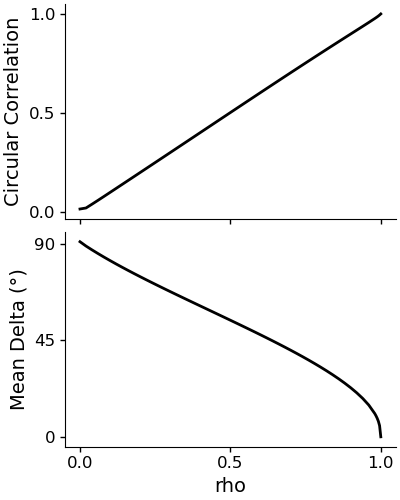

In [12]:
# x-shifted log
def log_func_xoff(x, a, b, c): 
    return a * np.log(x + b) + c

# logfit_params, pcov = curve_fit(log_func_xoff, rhos, corrs)
# logfit = log_func_xoff(rhos, *logfit_params)

poly_params = np.polyfit(rhos, corrs, 3)
print("poly params:", poly_params)
polyfit_fun = np.poly1d(poly_params)
polyfit = polyfit_fun(rhos)
fixed_rhos = np.array([r if r == 0 or r == 1 else bisect(lambda x: polyfit_fun(x) - r, 0, 1) for r in rhos])

real_corr_fig, real_corr_ax = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
real_corr_ax[0].plot(rhos, corrs, c="black", lw=2)
# real_corr_ax[0].plot(rhos, logfit, linestyle="--")
# real_corr_ax[0].plot(rhos, polyfit, linestyle="--")
real_corr_ax[0].set_yticks([0, 0.5, 1])
real_corr_ax[0].set_ylabel("Circular Correlation", fontsize=14)
real_corr_ax[1].plot(rhos, mean_abs_deltas, c="black", lw=2)
real_corr_ax[1].set_ylabel("Mean Delta (°)", fontsize=14)
real_corr_ax[1].set_yticks([0, 45, 90])

real_corr_ax[-1].set_xticks([0, 0.5, 1])
real_corr_ax[-1].set_xlabel("rho", fontsize=14)
real_corr_fig.set_layout_engine("compressed")
clean_axes(real_corr_ax, ticksize=12)

fix_lbl = "fix" if fix_rho_mode else ""
for ext in exts:
    real_corr_fig.savefig(
        os.path.join(fig_path, "angular_%srho_vs_real_corr%s_%isyn_%isteps%s" % (
            fix_lbl, rho_net_seed_lbl, n_syns, rho_steps, ext)),
        bbox_inches="tight"
    )

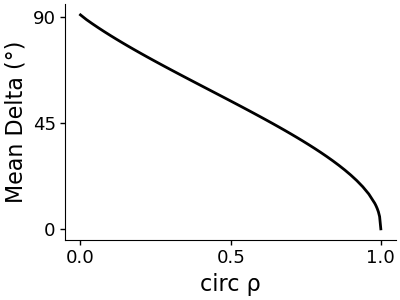

In [13]:
rho_vs_delta_fig, rho_vs_delta_ax = plt.subplots(1, figsize=(4, 3))
rho_vs_delta_ax.plot(rhos, mean_abs_deltas, c="black", lw=2)

rho_vs_delta_ax.set_yticks([0, 45, 90])
rho_vs_delta_ax.set_xticks([0, 0.5, 1])
rho_vs_delta_ax.set_ylabel("Mean Delta (°)", fontsize=16)
rho_vs_delta_ax.set_xlabel("circ ρ", fontsize=16)
rho_vs_delta_fig.set_layout_engine("compressed")
clean_axes(rho_vs_delta_ax, ticksize=13)

for ext in exts:
    rho_vs_delta_fig.savefig(
        os.path.join(fig_path, "circ_%srho_vs_delta%s_%isyn_%isteps%s" % (
            fix_lbl, rho_net_seed_lbl, n_syns, rho_steps, ext)),
        bbox_inches="tight"
    )

In [14]:
e_early_thresh = 5.

time_diff = {r: ts[:, has_gaba[r], 1] - ts[:, has_gaba[r], 0] for r, ts in times.items()}
abs_time_diff = {r: np.abs(diffs) for r, diffs in time_diff.items()}
abs_time_diff_sum = {r: np.sum(diffs, axis=1) for r, diffs in abs_time_diff.items()}
e_early_diff_sum = {
    r: np.array([np.sum(d[d > 0.]) for d in diff]) 
    for r, diff in time_diff.items()
}
e_early = {r: (diffs > e_early_thresh) for r, diffs in time_diff.items()}
e_early_sum = {r: np.sum(early, axis=1) for r, early in e_early.items()}
total_prob = {r: np.sum(pr, axis=0) for r, pr in dir_probs.items()}

### Aggregate probability of release polar plots of E and I at different angular rhos
These should be the same! Use `polar_rhos` to set which conditions to display.

avg gaba coverage = 0.50


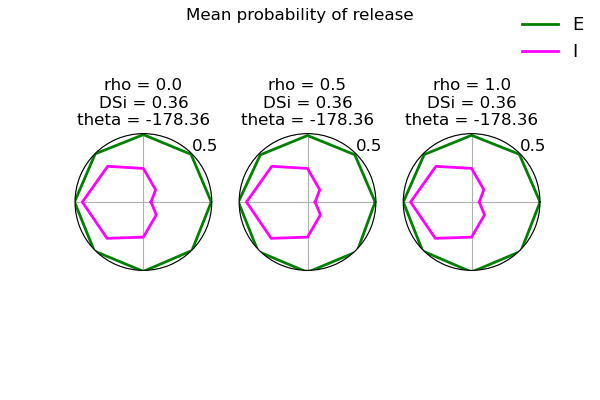

In [15]:
polar_rhos = [0.0, 0.5,  1.0]
# polar_rhos = [0.0, 0.9,  1.0]
radius_lim = 0.5

circ_total_prob = {r: pr[dir_sort, :] for r, pr in total_prob.items()}
# circ_total_prob = {r: pr[np.argsort(dir_labels), :] for r, pr in total_prob.items()}
circ_total_prob = {
    r: np.concatenate([pr, np.expand_dims(pr[0], axis=0)], axis=0) 
    for r, pr in circ_total_prob.items()
}
circ_mean_prob = {r: pr / dir_probs[r].shape[0] for r, pr in circ_total_prob.items()}
mean_prob = {r: pr / dir_probs[r].shape[0] for r, pr in total_prob.items()}

prob_polar_fig = plt.figure(figsize=(6, 4))
prob_polar_ax = []
for i, r in enumerate(polar_rhos):
    ax = prob_polar_fig.add_subplot(1, len(polar_rhos), i + 1, projection="polar")
    prob_polar_ax.append(ax)
    ax.plot(circle, circ_mean_prob[r][:, 0], c="green", linewidth=2, label="E" if not i else None)
    ax.plot(circle, circ_mean_prob[r][:, 1], c="magenta", linewidth=2, label="I" if not i else None)
    radius = np.max(circ_mean_prob[r]) if radius_lim is None else radius_lim
    dsi, theta = calc_tuning(total_prob[r][:, 1], dir_labels)
    ax.set_title("rho = %s\nDSi = %.2f\ntheta = %.2f" % (str(r), dsi, theta))
    ax.set_rmax(radius)
    ax.set_rticks([radius])
    ax.set_rlabel_position(45)
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=12)

prob_polar_fig.suptitle("Mean probability of release")
prob_polar_fig.legend(fontsize=13, frameon=False)

rho_lbl = str(polar_rhos)[1:-1].replace(", ", "_").replace(".", "p")
print("avg gaba coverage = %.2f" % (np.mean([np.sum(g) for g in has_gaba.values()]) / n_syns))
for ext in exts:
    prob_polar_fig.savefig(
        os.path.join(fig_path, "population_prob_polar%s_%isyn_%srho_%s%s" % (
            rho_net_seed_lbl, n_syns, fix_lbl, rho_lbl, ext)), bbox_inches="tight")

avg gaba coverage = 0.50


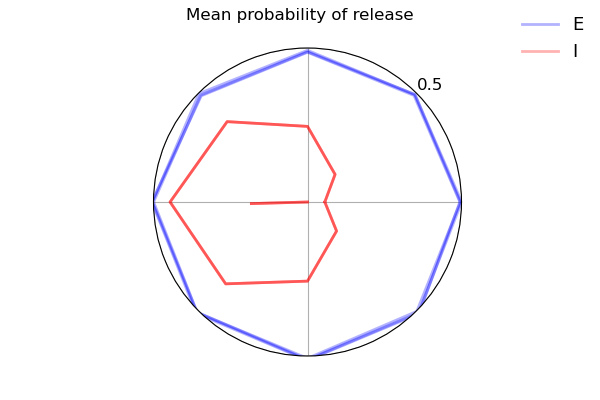

In [16]:
polar_rhos = [0.0, 0.5,  1.0]
# polar_rhos = [0.0, 0.9,  1.0]
radius_lim = 0.5

prob_polar_overlay_fig = plt.figure(figsize=(6, 4))
prob_polar_overlay_ax = prob_polar_overlay_fig.add_subplot(1, 1, 1, projection="polar")
ax = prob_polar_overlay_ax
for i, r in enumerate(polar_rhos):
    ax.plot(circle, circ_mean_prob[r][:, 0], c="blue", alpha=0.3, linewidth=2, label="E" if not i else None)
    ax.plot(circle, circ_mean_prob[r][:, 1], c="red", alpha=0.3, linewidth=2, label="I" if not i else None)
    radius = np.max(circ_mean_prob[r]) if radius_lim is None else radius_lim
    dsi, theta = calc_tuning(total_prob[r][:, 1], dir_labels)
    theta = np.radians(theta)
    ax.plot([theta, theta], [0, dsi * radius], c="red", alpha=0.3, lw=2)
    ax.set_rmax(radius)
    ax.set_rticks([radius])
    ax.set_rlabel_position(45)
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=12)

prob_polar_overlay_fig.suptitle("Mean probability of release")
prob_polar_overlay_fig.legend(fontsize=13, frameon=False)

rho_lbl = str(polar_rhos)[1:-1].replace(", ", "_").replace(".", "p")
print("avg gaba coverage = %.2f" % (np.mean([np.sum(g) for g in has_gaba.values()]) / n_syns))
for ext in exts:
    prob_polar_overlay_fig.savefig(
        os.path.join(fig_path, "population_prob_polar_overlay%s_%isyn_%srho_%s%s" % (
            rho_net_seed_lbl, n_syns, fix_lbl, rho_lbl, ext)),
        bbox_inches="tight"
    )

### Aggregate probability of release tuning of E and I at different angular rhos
Same as above, but with rho conditions overlaid to more easily compare. These should be the same! Use `tuning_rhos` to set which conditions to display.

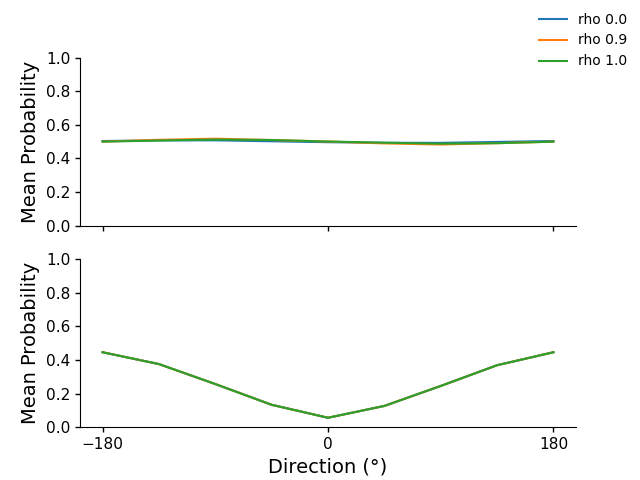

In [17]:
tuning_rhos = rhos
tuning_rhos = [0.0, 0.9,  1.0]
rho_prob_tuning_fig, rho_prob_tuning_ax = plt.subplots(2, sharex=True)
for r in tuning_rhos:
    rho_prob_tuning_ax[0].plot(full_dir_180, wrap_full_180(mean_prob[r][:, 0]), label="rho " + str(r))
    rho_prob_tuning_ax[1].plot(full_dir_180, wrap_full_180(mean_prob[r][:, 1]))

rho_prob_tuning_ax[0].set_ylim(0., 1.0)
rho_prob_tuning_ax[1].set_ylim(0., 1.0)

rho_prob_tuning_ax[0].set_xticks([-180, 0, 180])
rho_prob_tuning_ax[1].set_xlabel("Direction (°)", fontsize=14)

for ax in rho_prob_tuning_ax:
    ax.set_ylabel("Mean Probability", fontsize=14)
rho_prob_tuning_fig.legend(frameon=False)
clean_axes(rho_prob_tuning_ax)

### Generate and log ACh preferred thetas and probabilities for SAC networks with increasing plexus counts

In [18]:
n_plex_syns = 3000
plex_counts = [0, 1, 2, 3, 4]
plex_seed = None
print_sanity = False

ach_thetas, ach_dir_probs, plex_has_gaba, ach_vec_thetas, ach_vec_dsis = {}, {}, {}, {}, {}
rng = np.random.default_rng(plex_seed)

for n_plex in plex_counts:
    sac_net = SacNetwork(
        np.zeros((n_plex_syns, 2)),
        probs,
        1.0,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=n_plex,
    )
    plex_has_gaba[n_plex] = sac_net.gaba_here[:]
    ts = np.zeros((n_plex_syns, n_plex + 1))
    ts[:, 0] = sac_net.thetas["E"]
    if print_sanity:
        print("n_plex = %i (primary ACh tuning)" % n_plex)
        print("  GABA synapses: DSi %f, theta %f" 
              % calc_tuning(np.ones(np.sum(plex_has_gaba[n_plex])), sac_net.thetas["E"][plex_has_gaba[n_plex]]))
        no_gaba = (1 - plex_has_gaba[n_plex]).astype(bool)
        print("  GABAless synapses: DSi %f, theta %f" 
              % calc_tuning(np.ones(np.sum(no_gaba)), sac_net.thetas["E"][no_gaba]))
        print("  overall: DSi %f, theta %f" % calc_tuning(np.ones(n_plex_syns), sac_net.thetas["E"]))
    if n_plex:
        ts[:, 1:] = sac_net.thetas["PLEX"]
        ones = np.ones(n_plex + 1)
        ach_vec_dsis[n_plex], ach_vec_thetas[n_plex]  = zip(*(calc_tuning(ones, degs) for degs in ts))
        ach_vec_thetas[n_plex] = np.array(ach_vec_thetas[n_plex])
        ach_vec_dsis[n_plex] = np.array(ach_vec_dsis[n_plex])
    else:
        ach_vec_thetas[0] = ts[:, 0]
        ach_vec_dsis[0] = np.ones(n_plex_syns)
    ach_thetas[n_plex] = ts
    ach_dir_probs[n_plex] = np.zeros((n_plex_syns, 8, n_plex + 1))
    ach_dir_probs[n_plex][:, :, 0] = sac_net.probs["E"]
    if n_plex:
        ach_dir_probs[n_plex][:, :, 1:] = sac_net.probs["PLEX"]

ach_syn_probs = {n: pr.sum(axis=2) for n, pr in ach_dir_probs.items()}
ach_total_prob = {n: pr.mean(axis=0) for n, pr in ach_syn_probs.items()}
circ_ach_total_prob = {n: pr[dir_sort] for n, pr in ach_total_prob.items()}
circ_ach_total_prob = {
    n: np.concatenate([pr, np.expand_dims(pr[0], axis=0)], axis=0) 
    for n, pr in circ_ach_total_prob.items()
}

### Total ACh release probability polar plot for each plexus condition
Ensure that the addition of non-directional ACh inputs does not distort tuning.

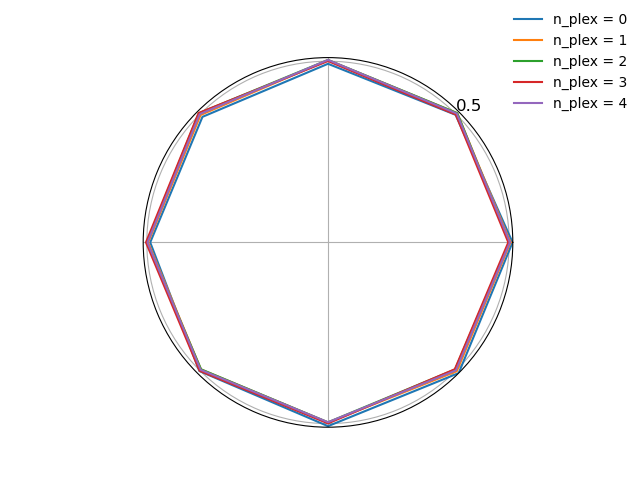

In [19]:
ach_tuning_plex_polar_fig = plt.figure()
ach_tuning_plex_polar_ax = ach_tuning_plex_polar_fig.add_subplot(111, projection="polar")
for n, prs in circ_ach_total_prob.items():
    ach_tuning_plex_polar_ax.plot(circle, prs, label="n_plex = %i" % n)
    
ach_tuning_plex_polar_ax.set_rmax(0.51)
ach_tuning_plex_polar_ax.set_rticks([0.5])
ach_tuning_plex_polar_ax.set_rlabel_position(45)
ach_tuning_plex_polar_ax.set_thetagrids([0, 90, 180, 270])
ach_tuning_plex_polar_ax.set_xticklabels([])
ach_tuning_plex_polar_ax.tick_params(labelsize=12)
ach_tuning_plex_polar_fig.legend(frameon=False)

### Total ACh release probability tuning curves for each plexus condition
Ensure that the addition of non-directional ACh inputs does not distort tuning.

n_plex 0
  variance 5.4763850740284125e-05
  range 0.02003194696219518
n_plex 1
  variance 1.1280145363743017e-05
  range 0.00838392185300929
n_plex 2
  variance 1.4364679939834284e-05
  range 0.00930139450520906
n_plex 3
  variance 8.216411961273136e-06
  range 0.009946450453023337
n_plex 4
  variance 6.68161046645656e-06
  range 0.007296474475620762


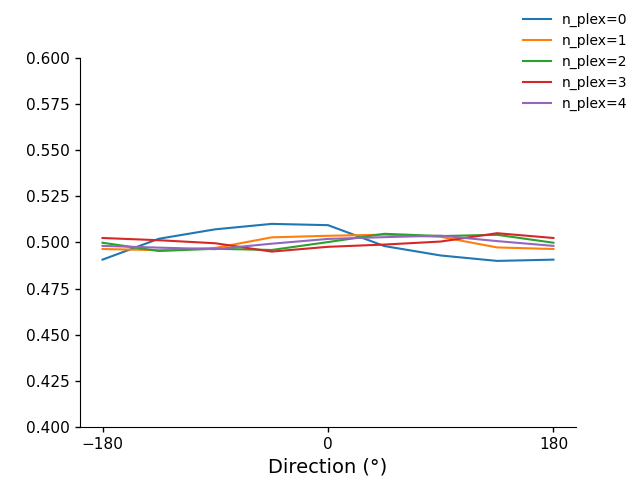

In [20]:
ach_tuning_plex_fig, ach_tuning_plex_ax = plt.subplots(1)
for n, prs in ach_total_prob.items():
    ach_tuning_plex_ax.plot(full_dir_180, wrap_full_180(prs), label="n_plex=%i" % n)
    print("n_plex %i\n  variance %s\n  range %s" % (n, np.var(prs[:-1]), np.max(prs) - np.min(prs)))

ach_tuning_plex_ax.set_ylim(0.4, 0.6)
ach_tuning_plex_ax.set_xticks([-180, 0, 180])
ach_tuning_plex_ax.set_xlabel("Direction (°)", fontsize=14)
ach_tuning_plex_fig.legend(frameon=False)
clean_axes(ach_tuning_plex_ax)

### Vector sum of the angles of preference directly (not based on tuning probabilities).
Vector length of 1 (stand-in for DSi) is used for all angles.

== ACh vector tuning at GABA synpases ==
n_plex = 0: DSi 0.614419, theta -178.127290
n_plex = 1: DSi 0.411083, theta 173.702130
n_plex = 2: DSi 0.317638, theta 174.340478
n_plex = 3: DSi 0.271229, theta 178.584482
n_plex = 4: DSi 0.236076, theta 174.850860


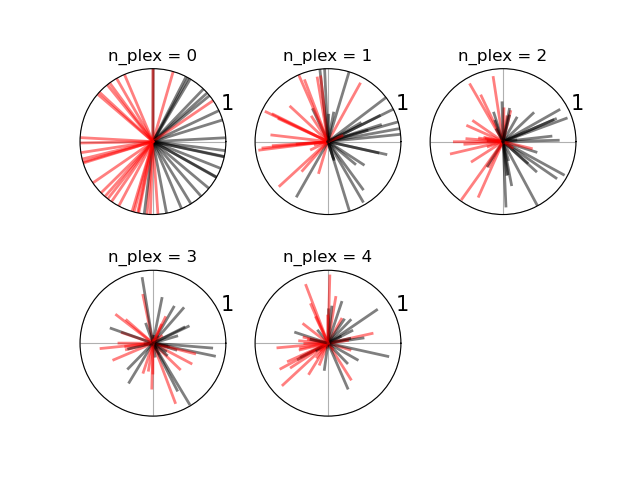

In [21]:
syn_sample = 50
max_rows = 2
show_gabaless = True
n_rows = min(max_rows, len(plex_counts))
n_cols = max(1, int(np.ceil(len(plex_counts) / n_rows)))

ach_synapse_vec_tuning_polar_fig = plt.figure()
synapse_vec_tuning_polars = []
print("== ACh vector tuning at GABA synpases ==")
for i, n_plex in enumerate(plex_counts):
    ax = ach_synapse_vec_tuning_polar_fig.add_subplot(n_rows, n_cols, i + 1, projection="polar")
    synapse_vec_tuning_polars.append(ax)
    dsi, theta = calc_tuning(
        np.ones(np.sum(plex_has_gaba[n_plex])), ach_vec_thetas[n_plex][plex_has_gaba[n_plex]])
    print("n_plex = %i: DSi %f, theta %f" % (n_plex, dsi, theta))
    for j in rng.integers(low=0, high=n_plex_syns, size=syn_sample):
        if plex_has_gaba[n_plex][j] or show_gabaless:
            color = "red" if plex_has_gaba[n_plex][j] else "black"
            theta = np.radians(ach_vec_thetas[n_plex][j])  
            ax.plot(
                [theta, theta],
                [0.0, ach_vec_dsis[n_plex][j]],
                color=color,
                alpha=0.5,
                linewidth=2,
            )
    ax.set_rmax(1.0)
    ax.set_rticks([1.0])
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=15)
    ax.set_title("n_plex = %i" % n_plex)

### Vector sum of release probabilities calculated for 8 directions

== ACh probability tuning at GABA synpases ==
n_plex = 0: DSi 0.372863, theta -178.171238
n_plex = 1: DSi 0.191901, theta 174.807845
n_plex = 2: DSi 0.122279, theta 175.499670
n_plex = 3: DSi 0.096413, theta 178.554699
n_plex = 4: DSi 0.070900, theta 173.970413
avg gaba coverage = 0.50


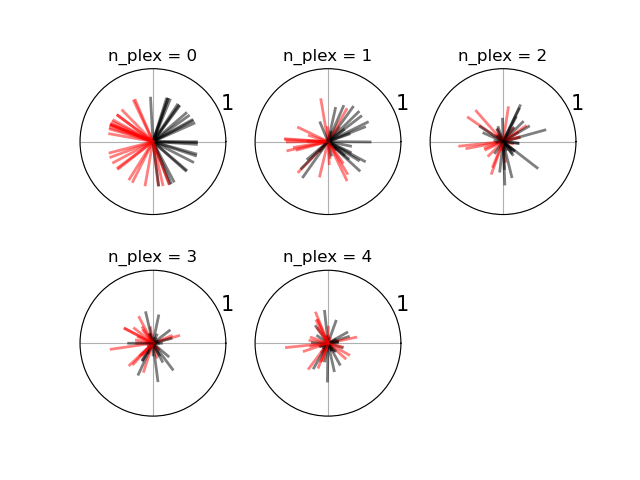

In [22]:
display_plexs = plex_counts
syn_sample = 50
show_mean_arrows = False
max_rows = 2
show_gabaless = True
seed = 3

rng = np.random.default_rng(seed)
n_rows = min(max_rows, len(plex_counts))
n_cols = max(1, int(np.ceil(len(plex_counts) / n_rows)))
ach_synapse_prob_tuning_polar_fig = plt.figure()
synapse_prob_tuning_polars = []
print("== ACh probability tuning at GABA synpases ==")
for i, n_plex in enumerate(plex_counts):
    ax = ach_synapse_prob_tuning_polar_fig.add_subplot(n_rows, n_cols, i + 1, projection="polar")
    synapse_prob_tuning_polars.append(ax)
    mean_dsi, mean_theta = calc_tuning(
        np.sum(ach_syn_probs[n_plex][plex_has_gaba[n_plex]], axis=0), dir_labels)
    print("n_plex = %i: DSi %f, theta %f" % (n_plex, mean_dsi, mean_theta))
    for j in rng.integers(low=0, high=n_plex_syns, size=syn_sample):
        if show_gabaless or plex_has_gaba[n_plex][j]:
            color = "red" if plex_has_gaba[n_plex][j] else "black"
            dsi, theta = calc_tuning(ach_syn_probs[n_plex][j], dir_labels)
            ax.plot(
                [np.radians(theta)] * 2,
                [0.0, dsi],
                color=color,
                alpha=0.5,
                linewidth=2,
            )
            if show_mean_arrows:
                ax.plot(
                    [np.radians(mean_theta)] * 2,
                    [0.0, mean_dsi],
                    color=color,
                    alpha=1,
                    linewidth=3,
                )
    ax.set_rmax(1.0)
    ax.set_rticks([1.0])
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=15)
    ax.set_title("n_plex = %i" % n_plex)
    
plex_lbl = str(display_plexs)[1:-1].replace(", ", "_")
seed_lbl = "_seed%i" % seed if seed is not None else ""
mean_lbl = "_with_means" if show_mean_arrows else ""
print("avg gaba coverage = %.2f" % (np.mean([np.sum(g) for g in has_gaba.values()]) / n_syns))
for ext in exts:
    ach_synapse_prob_tuning_polar_fig.savefig(
        os.path.join(fig_path, "ach_synapse_prob_tuning_n%i%s_plex_%s%s%s" % (
            syn_sample, seed_lbl, plex_lbl, mean_lbl, ext)),
        bbox_inches="tight")

### Example of individual ACh synapse tuning
Use `only_with_gaba` to set whether to restrict viewing to EI pair synapses (otherwise all synapses are considered).

original ACh theta = 174.568397
theta from probabilities = 173.224168


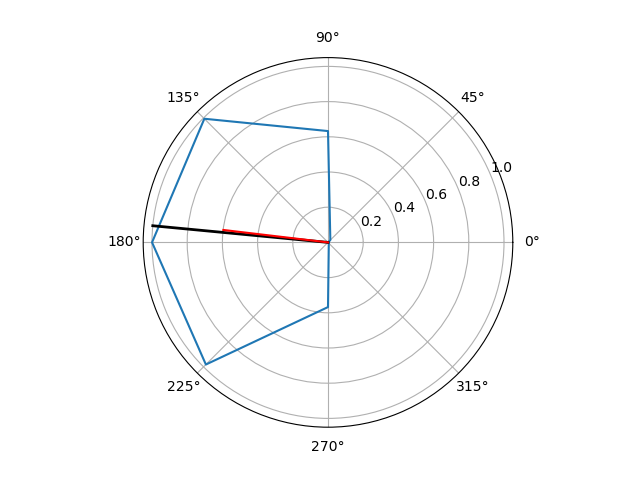

In [23]:
only_with_gaba = True
if only_with_gaba:
    syn = rng.choice(np.argwhere(plex_has_gaba[0])[:, 0])
else:
    syn = rng.integers(low=0, high=n_syns)
    
example_syn_tuning_fig = plt.figure()
example_syn_tuning_ax = example_syn_tuning_fig.add_subplot(111, projection="polar")

example_syn_tuning_ax.plot(circle, wrap_circ(ach_syn_probs[0][syn][dir_sort]), label="probability")
vec_theta = ach_vec_thetas[0][syn]
example_syn_tuning_ax.plot(
    [np.radians(vec_theta)] * 2, [0.0, 1.0], color="black", linewidth=2, label="og angle")
dsi, theta = calc_tuning(ach_syn_probs[0][syn], dir_labels)
example_syn_tuning_ax.plot([np.radians(theta)] * 2, [0, dsi], color="red", label="")

scaled = (" (%f)" % scale_180_from_360(vec_theta)) if vec_theta > 180 else ""
print("original ACh theta = %f%s" % (ach_vec_thetas[0][syn], scaled))
print("theta from probabilities = %f" % theta)